<a href="https://colab.research.google.com/github/bartolomeoadrian/computer-vision/blob/main/11_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Cargar librerías

In [2]:
import os, math, itertools, time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim   = 100
img_size     = 28
img_channels = 1
batch_size   = 128
epochs       = 10
lr           = 2e-4
beta1        = 0.5
sample_dir   = "/content/samples"
os.makedirs(sample_dir, exist_ok=True)

# 2 - Cargar dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1, 1]
])
train_ds = datasets.FashionMNIST(root="/content/data", train=True, transform=transform, download=True)
loader   = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2, pin_memory=True)


100%|██████████| 26.4M/26.4M [00:03<00:00, 7.01MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 138kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.24MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.6MB/s]


# 3 - Definir una red

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_dim=28*28):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),

            nn.Linear(1024, img_dim),
            nn.Tanh()  # salida en [-1, 1]
        )

    def forward(self, z):
        x = self.net(z)
        return x.view(z.size(0), 1, img_size, img_size)

class Discriminator(nn.Module):
    def __init__(self, img_dim=28*28):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

G = Generator(latent_dim).to(device)
D = Discriminator().to(device)

# 4 - Definir una función de pérdida y un optimizador

In [5]:
criterion = nn.BCELoss()
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

# 5 - Entrenar a la red

In [9]:
losses_D, losses_G = [], []

# ---- Ruido fijo para monitorear progreso ----
fixed_z = torch.randn(64, latent_dim, device=device)

def save_samples(step, z=fixed_z):
    G.eval()
    with torch.no_grad():
        fake = G(z).cpu()
        grid = utils.make_grid(fake, nrow=8, normalize=True, value_range=(-1, 1))
        utils.save_image(grid, f"{sample_dir}/step_{step:06d}.png")
    G.train()

# ---- Entrenamiento ----
global_step = 0
start = time.time()
for epoch in range(1, epochs + 1):
    for real, _ in loader:
        real = real.to(device, non_blocking=True)
        b = real.size(0)

        # --- Entrena Discriminador
        z = torch.randn(b, latent_dim, device=device)
        fake = G(z).detach()

        D_real = D(real).squeeze()
        D_fake = D(fake).squeeze()

        loss_D_real = criterion(D_real, torch.ones_like(D_real))
        loss_D_fake = criterion(D_fake, torch.zeros_like(D_fake))
        loss_D = (loss_D_real + loss_D_fake) / 2

        opt_D.zero_grad(set_to_none=True)
        loss_D.backward()
        opt_D.step()

        # --- Entrena Generador
        z = torch.randn(b, latent_dim, device=device)
        fake = G(z)
        D_fake_for_G = D(fake).squeeze()
        loss_G = criterion(D_fake_for_G, torch.ones_like(D_fake_for_G))

        opt_G.zero_grad(set_to_none=True)
        loss_G.backward()
        opt_G.step()

        # Logging simple
        if global_step % 200 == 0:
            print(f"[epoch {epoch:02d}/{epochs}] step {global_step:05d} | "
                  f"loss_D: {loss_D.item():.3f} | loss_G: {loss_G.item():.3f}")
            save_samples(global_step)

        global_step += 1

        losses_D.append(loss_D.item())
        losses_G.append(loss_G.item())

    # muestra al final de cada época
    save_samples(global_step)

[epoch 01/10] step 00000 | loss_D: 0.621 | loss_G: 0.967
[epoch 01/10] step 00200 | loss_D: 0.680 | loss_G: 1.000
[epoch 01/10] step 00400 | loss_D: 0.624 | loss_G: 1.036
[epoch 02/10] step 00600 | loss_D: 0.651 | loss_G: 1.042
[epoch 02/10] step 00800 | loss_D: 0.701 | loss_G: 1.029
[epoch 03/10] step 01000 | loss_D: 0.644 | loss_G: 0.743
[epoch 03/10] step 01200 | loss_D: 0.688 | loss_G: 0.758
[epoch 03/10] step 01400 | loss_D: 0.653 | loss_G: 0.850
[epoch 04/10] step 01600 | loss_D: 0.657 | loss_G: 0.894
[epoch 04/10] step 01800 | loss_D: 0.633 | loss_G: 0.902
[epoch 05/10] step 02000 | loss_D: 0.663 | loss_G: 1.107
[epoch 05/10] step 02200 | loss_D: 0.636 | loss_G: 1.006
[epoch 06/10] step 02400 | loss_D: 0.666 | loss_G: 0.972
[epoch 06/10] step 02600 | loss_D: 0.647 | loss_G: 1.083
[epoch 06/10] step 02800 | loss_D: 0.685 | loss_G: 0.795
[epoch 07/10] step 03000 | loss_D: 0.668 | loss_G: 0.803
[epoch 07/10] step 03200 | loss_D: 0.650 | loss_G: 0.831
[epoch 08/10] step 03400 | loss

# 6 - Prueba de la red

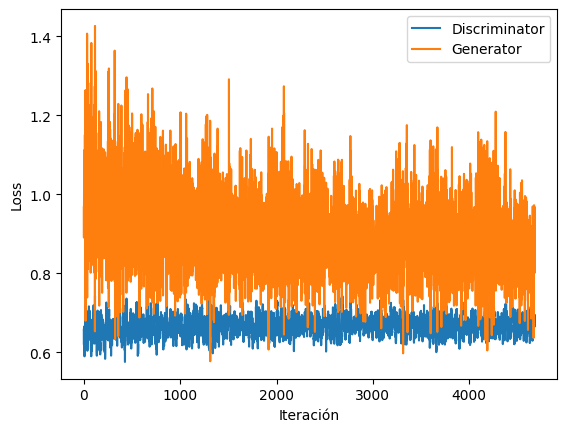

In [10]:
plt.plot(losses_D, label="Discriminator")
plt.plot(losses_G, label="Generator")
plt.xlabel("Iteración")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 7 - Generación

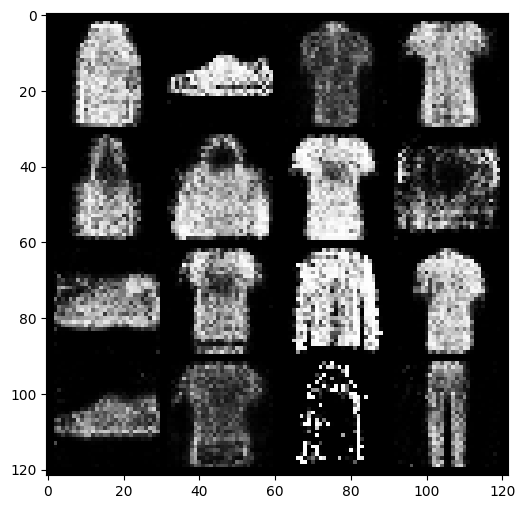

In [11]:
G.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim, device=device)   # 16 vectores de ruido
    fake_imgs = G(z).cpu()

# Mostrar un grid 4x4
grid = utils.make_grid(fake_imgs, nrow=4, normalize=True, value_range=(-1, 1))
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0))
plt.show()